# Polynomial Fitting and Regularization (Jupyter Demo)

In this demo, we use a polynomial model to fit the function

\[
f(x) = 1.2 \exp(-0.9 (x - 0.3)^2) + 0.15 x
\]

with artificial noise.

The goal is to demonstrate:
- how high-degree polynomials can overfit noisy data,
- why oscillatory behavior appears,
- and how regularization helps improve generalization.


## Step 1: Environment setup

We first import the required libraries and set up the environment.
To make the results reproducible, we fix the random seed.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

rng = np.random.default_rng(7)
plt.rcParams["figure.figsize"] = (7, 4.5)


## Step 2: Generate synthetic data

We generate training and validation data from a smooth, non-oscillatory
ground-truth function. Artificial noise is added to simulate measurement
errors.

Because the true function is smooth, any oscillations in the fitted curve
will clearly indicate overfitting rather than properties of the data.


In [5]:
n_train = 16
n_val = 120

X_train = rng.uniform(-2.0, 2.0, size=n_train)
X_val   = rng.uniform(-2.0, 2.0, size=n_val)

def f(x):
    return 1.2 * np.exp(-0.9 * (x - 0.3)**2) + 0.15 * x

noise_std = 0.12
y_train = f(X_train) + rng.normal(0, noise_std, size=n_train)
y_val   = f(X_val)   + rng.normal(0, noise_std, size=n_val)

X_train_2d = X_train.reshape(-1, 1)
X_val_2d   = X_val.reshape(-1, 1)

x_grid = np.linspace(-2.0, 2.0, 800)
X_grid_2d = x_grid.reshape(-1, 1)
y_true_grid = f(x_grid)


## Step 3: Visualize the data

Before fitting any model, we visualize the true function together with
the noisy samples. This helps us build intuition about the underlying
structure we expect the model to learn.


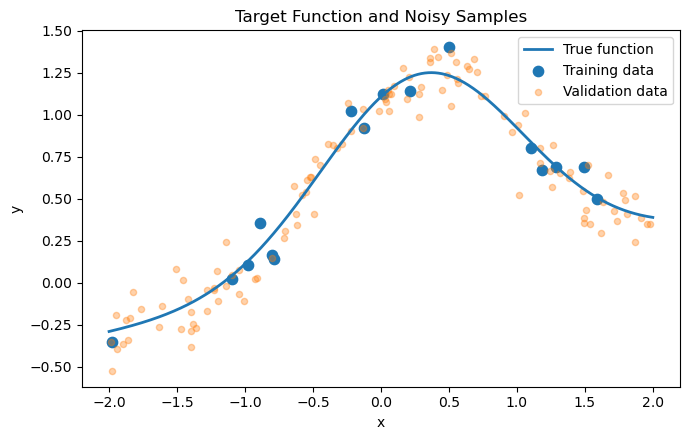

In [7]:
plt.figure()
plt.plot(x_grid, y_true_grid, linewidth=2, label="True function")
plt.scatter(X_train, y_train, s=55, label="Training data")
plt.scatter(X_val, y_val, s=20, alpha=0.35, label="Validation data")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Target Function and Noisy Samples")
plt.legend()
plt.tight_layout()
plt.show()


## Step 4: High-degree polynomial fitting (no regularization)

We fit a high-degree polynomial using ordinary least squares.
This model is highly flexible and can fit the training data very well,
but may exhibit strong oscillations and poor generalization.


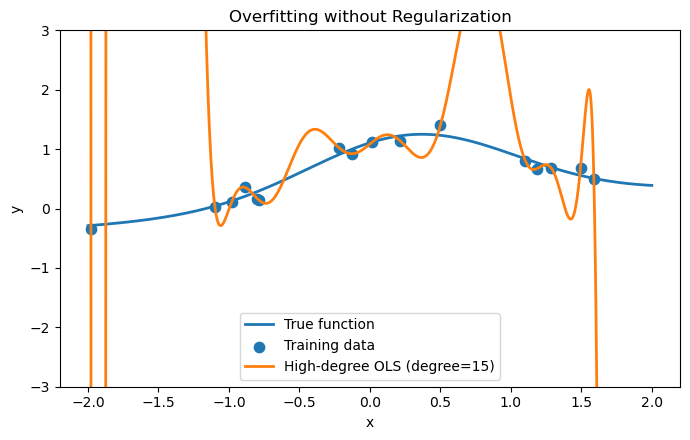

In [9]:
degree = 15

ols_model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())
])

ols_model.fit(X_train_2d, y_train)
y_ols_grid = ols_model.predict(X_grid_2d)

plt.figure()
plt.plot(x_grid, y_true_grid, linewidth=2, label="True function")
plt.scatter(X_train, y_train, s=55, label="Training data")
plt.plot(x_grid, y_ols_grid, linewidth=2, label=f"High-degree OLS (degree={degree})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Overfitting without Regularization")
plt.legend()
plt.ylim(-3,3)
plt.tight_layout()
plt.show()


## Step 5: Quantifying overfitting

We compare training and validation errors, inspect the magnitude of the
learned coefficients, and measure the curvature of the fitted curve.
These quantities help diagnose overfitting quantitatively.


In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def wiggliness(y, x):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    return np.mean(np.abs(d2y))

train_rmse_ols = rmse(y_train, ols_model.predict(X_train_2d))
val_rmse_ols   = rmse(y_val,   ols_model.predict(X_val_2d))

ols_coefs = ols_model.named_steps["ols"].coef_
coef_norm_ols = np.linalg.norm(ols_coefs, ord=2)

wiggle_ols = wiggliness(y_ols_grid, x_grid)

print(f"OLS train RMSE: {train_rmse_ols:.4f}")
print(f"OLS val   RMSE: {val_rmse_ols:.4f}")
print(f"OLS ||coefficients||_2: {coef_norm_ols:.2f}")
print(f"OLS wiggliness: {wiggle_ols:.2f}")


OLS train RMSE: 0.0000
OLS val   RMSE: 1276.2136
OLS ||coefficients||_2: 264715.67
OLS wiggliness: 47729.10


## Step 6: Regularization

Instead of reducing the polynomial degree, we keep the same model but
penalize large coefficients using L2 regularization (Ridge regression).

This discourages oscillatory solutions while preserving model flexibility.


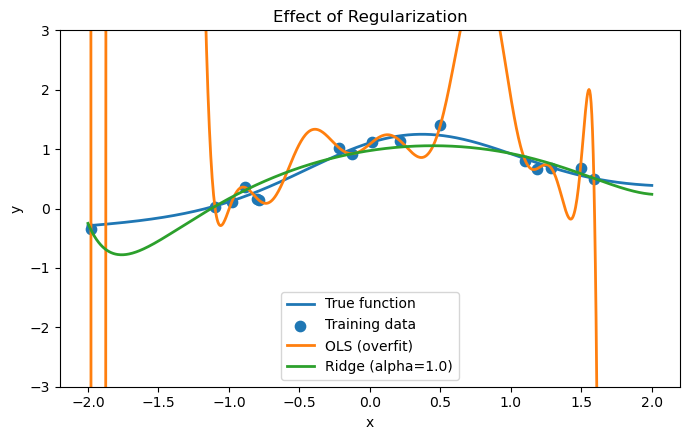

In [13]:
alpha = 1.0

ridge_model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=alpha))
])

ridge_model.fit(X_train_2d, y_train)
y_ridge_grid = ridge_model.predict(X_grid_2d)

plt.figure()
plt.plot(x_grid, y_true_grid, linewidth=2, label="True function")
plt.scatter(X_train, y_train, s=55, label="Training data")
plt.plot(x_grid, y_ols_grid, linewidth=2, label="OLS (overfit)")
plt.plot(x_grid, y_ridge_grid, linewidth=2, label=f"Ridge (alpha={alpha})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Effect of Regularization")
plt.legend()
plt.ylim(-3,3)
plt.tight_layout()
plt.show()


## Step 7: Effect of regularization

We compare the regularized and unregularized models in terms of
generalization error, coefficient magnitude, and curve smoothness.


In [15]:
train_rmse_ridge = rmse(y_train, ridge_model.predict(X_train_2d))
val_rmse_ridge   = rmse(y_val,   ridge_model.predict(X_val_2d))

ridge_coefs = ridge_model.named_steps["ridge"].coef_
coef_norm_ridge = np.linalg.norm(ridge_coefs, ord=2)

wiggle_ridge = wiggliness(y_ridge_grid, x_grid)

print(f"OLS   : train RMSE={train_rmse_ols:.4f}, val RMSE={val_rmse_ols:.4f}, ||coef||={coef_norm_ols:.2f}, wiggle={wiggle_ols:.2f}")
print(f"Ridge : train RMSE={train_rmse_ridge:.4f}, val RMSE={val_rmse_ridge:.4f}, ||coef||={coef_norm_ridge:.2f}, wiggle={wiggle_ridge:.2f}")


OLS   : train RMSE=0.0000, val RMSE=1276.2136, ||coef||=264715.67, wiggle=47729.10
Ridge : train RMSE=0.1493, val RMSE=0.2169, ||coef||=0.59, wiggle=2.52


## Step 8: Choosing the regularization strength

The regularization parameter λ controls the trade-off between bias and
variance. We select λ by minimizing the validation (cross-validation)
error.


Best alpha: 0.0149


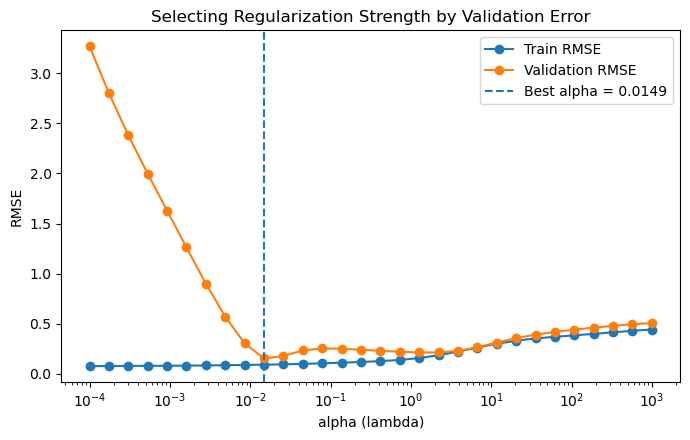

In [17]:
alphas = np.logspace(-4, 3, 30)

train_errors = []
val_errors = []

for a in alphas:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    model.fit(X_train_2d, y_train)
    train_errors.append(rmse(y_train, model.predict(X_train_2d)))
    val_errors.append(rmse(y_val, model.predict(X_val_2d)))

train_errors = np.array(train_errors)
val_errors = np.array(val_errors)

best_idx = np.argmin(val_errors)
best_alpha = alphas[best_idx]

print(f"Best alpha: {best_alpha:.3g}")

plt.figure()
plt.semilogx(alphas, train_errors, marker="o", label="Train RMSE")
plt.semilogx(alphas, val_errors, marker="o", label="Validation RMSE")
plt.axvline(best_alpha, linestyle="--", label=f"Best alpha = {best_alpha:.3g}")
plt.xlabel("alpha (lambda)")
plt.ylabel("RMSE")
plt.title("Selecting Regularization Strength by Validation Error")
plt.legend()
plt.tight_layout()
plt.show()


## Step 9: Final model with selected λ

We refit the model using the selected regularization strength and compare
it with the overfitting solution.


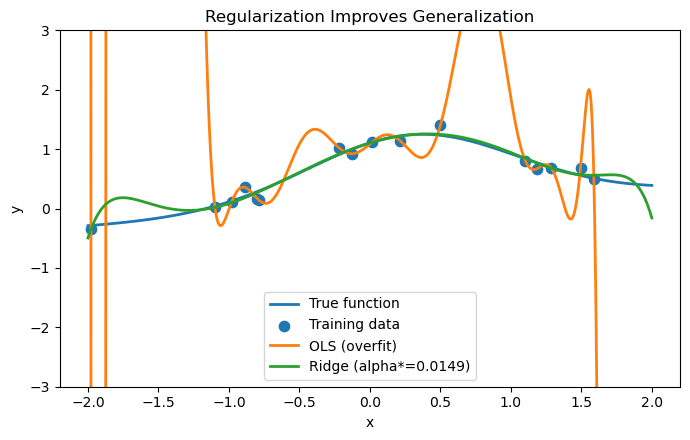

In [19]:
best_model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

best_model.fit(X_train_2d, y_train)
y_best_grid = best_model.predict(X_grid_2d)

plt.figure()
plt.plot(x_grid, y_true_grid, linewidth=2, label="True function")
plt.scatter(X_train, y_train, s=55, label="Training data")
plt.plot(x_grid, y_ols_grid, linewidth=2, label="OLS (overfit)")
plt.plot(x_grid, y_best_grid, linewidth=2, label=f"Ridge (alpha*={best_alpha:.3g})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regularization Improves Generalization")
plt.legend()
plt.ylim(-3,3)
plt.tight_layout()
plt.show()
